In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress
from api_keys import weather_api_key

# Import the OpenWeatherMap API key
from api_keys import weather_api_key

# Import citipy to determine the cities based on latitude and longitude
from citipy import citipy


In [2]:
# Set the API base URL
BASE_URL = f"https://api.openweathermap.org/data/2.5/weather?appid={weather_api_key}&units=imperial"
NUM_POINTS = 50    # DEBUG 1500

In [3]:
# Empty list for holding the latitude and longitude combinations
lat_lngs = []

# Empty list for holding the cities names
cities = []

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

# Create a set of random lat and lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=NUM_POINTS)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=NUM_POINTS)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
print(f"Number of cities in the list: {len(cities)}")

Number of cities in the list: 44


In [4]:
# Define an empty list to fetch the weather data for each city
city_data = []

# Print to logger
print("Beginning Data Retrieval     ")
print("-----------------------------")

# Create counters
record_count = 1
set_count = 1

# Loop through all the cities in our list to fetch weather data
for i, city in enumerate(cities):
    # Group cities in sets of 50 for logging purposes
    if (i % 50 == 0 and i >= 50):
        set_count += 1
        record_count = 0

    # Create endpoint URL with each city
    city_url = f"{BASE_URL}&q={city.replace(' ', '+')}"

    # Log the url, record, and set numbers
    print("Processing Record %s of Set %s | %s" % (record_count, set_count, city))

    # Add 1 to the record count
    record_count += 1

    # Parse the JSON and retrieve data
    city_weather = requests.get(city_url).json()

    # Check if the 'cod' key is 200, indicating a successful API call
    if city_weather['cod'] == 200:
        # Parse out latitude, longitude, max temp, humidity, cloudiness, wind speed, country, and date
        city_lat = city_weather["coord"]["lat"]
        city_lng = city_weather["coord"]["lon"]
        city_max_temp = city_weather["main"]["temp_max"]
        city_humidity = city_weather["main"]["humidity"]
        city_clouds = city_weather["clouds"]["all"]
        city_wind = city_weather["wind"]["speed"]
        city_country = city_weather["sys"]["country"]
        city_date = city_weather["dt"]

        # Append the City information into city_data list
        city_data.append({"City": city, 
                            "Lat": city_lat, 
                            "Lng": city_lng, 
                            "Max Temp": city_max_temp,
                            "Humidity": city_humidity,
                            "Cloudiness": city_clouds,
                            "Wind Speed": city_wind,
                            "Country": city_country,
                            "Date": city_date})
    else:
        print(f"City not found. Skipping... {city_weather}")
        
    # Wait for a second to not exceed the API rate limit
    time.sleep(1)

# Indicate that Data Loading is complete 
print("-----------------------------")
print("Data Retrieval Complete      ")
print("-----------------------------")

Beginning Data Retrieval     
-----------------------------
Processing Record 1 of Set 1 | kone
Processing Record 2 of Set 1 | margaret river
Processing Record 3 of Set 1 | taiohae
City not found. Skipping... {'cod': '404', 'message': 'city not found'}
Processing Record 4 of Set 1 | mount isa
Processing Record 5 of Set 1 | vernon
Processing Record 6 of Set 1 | nouadhibou
Processing Record 7 of Set 1 | hasaki
Processing Record 8 of Set 1 | san patricio
Processing Record 9 of Set 1 | nagqu
Processing Record 10 of Set 1 | bethel
Processing Record 11 of Set 1 | lihue
Processing Record 12 of Set 1 | college
Processing Record 13 of Set 1 | grytviken
Processing Record 14 of Set 1 | ambovombe
Processing Record 15 of Set 1 | waitangi
Processing Record 16 of Set 1 | bridgewater
Processing Record 17 of Set 1 | invercargill
Processing Record 18 of Set 1 | gadzhiyevo
Processing Record 19 of Set 1 | laguna
Processing Record 20 of Set 1 | igrim
Processing Record 21 of Set 1 | adamstown
Processing Rec

             City      Lat       Lng  Max Temp  Humidity  Cloudiness  \
0            kone -21.0595  164.8658     63.54        81          94   
1  margaret river -33.9500  115.0667     47.95        85          99   
2       mount isa -20.7333  139.5000     69.57        46         100   
3          vernon  50.2581 -119.2691     84.61        27           0   
4      nouadhibou  20.9310  -17.0347     73.38        78          90   

   Wind Speed Country        Date  
0        5.46      NC  1691175915  
1        8.16      AU  1691175920  
2        8.05      AU  1691175924  
3        2.30      CA  1691175698  
4       21.85      MR  1691175927  


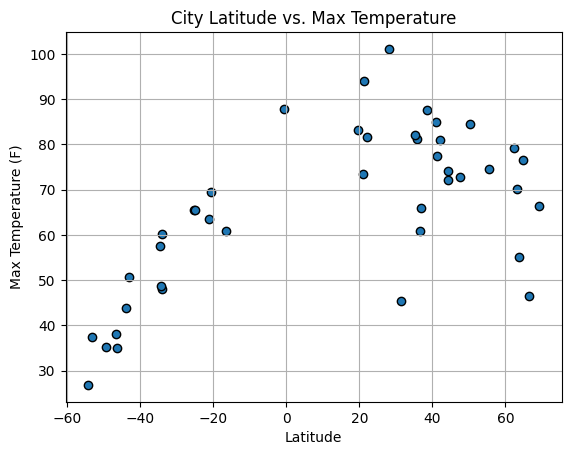

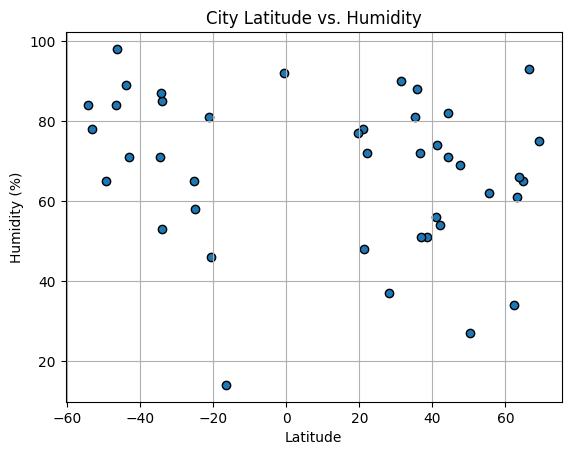

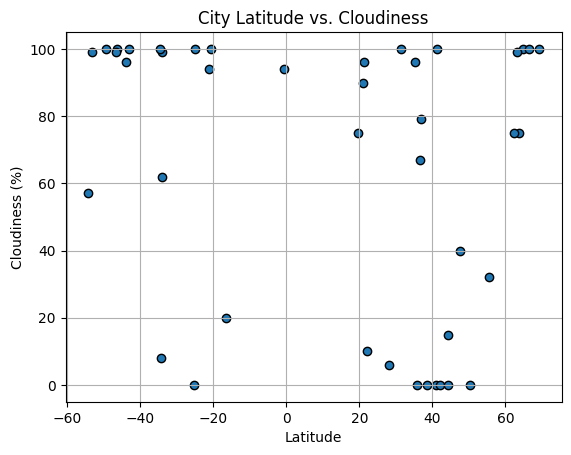

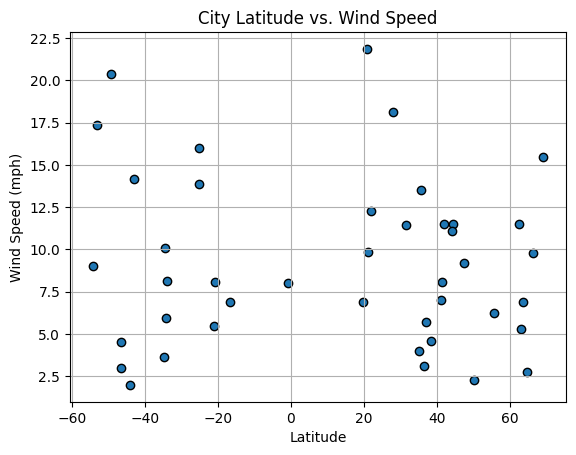

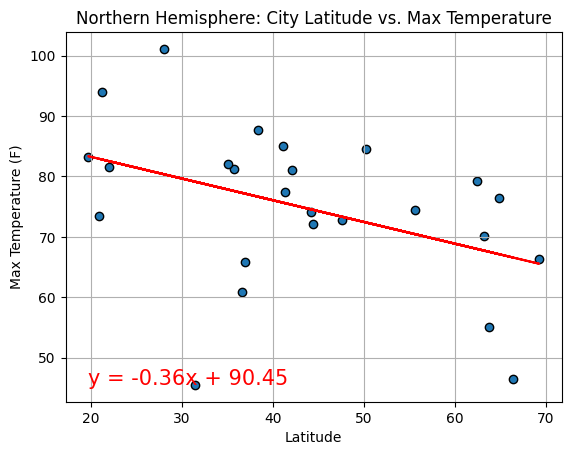

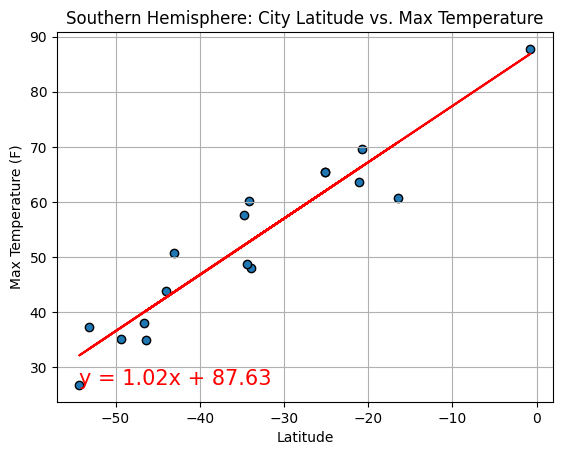

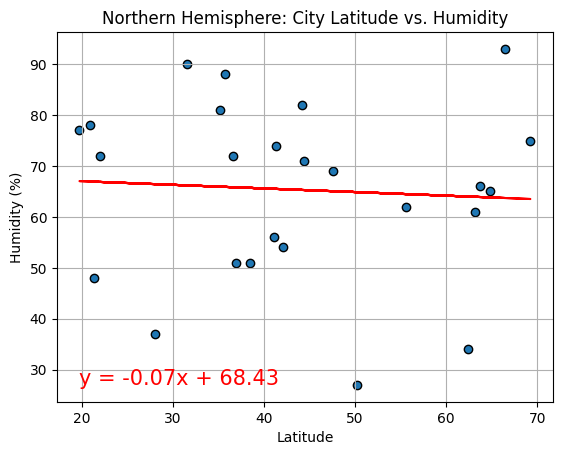

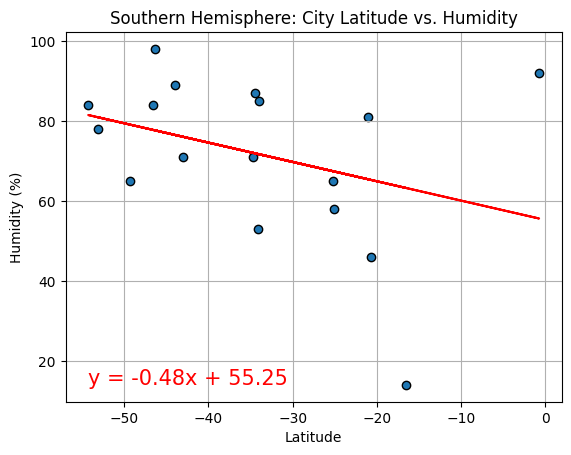

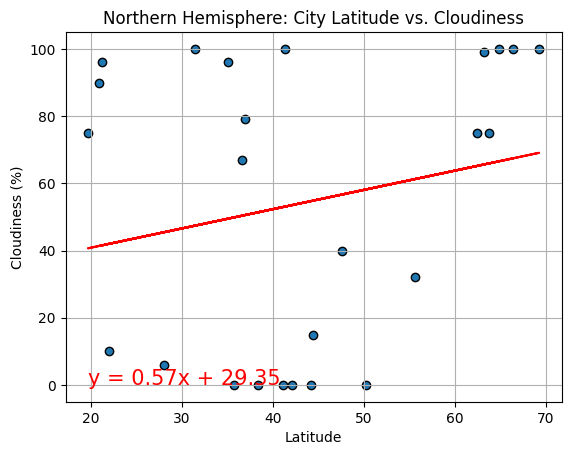

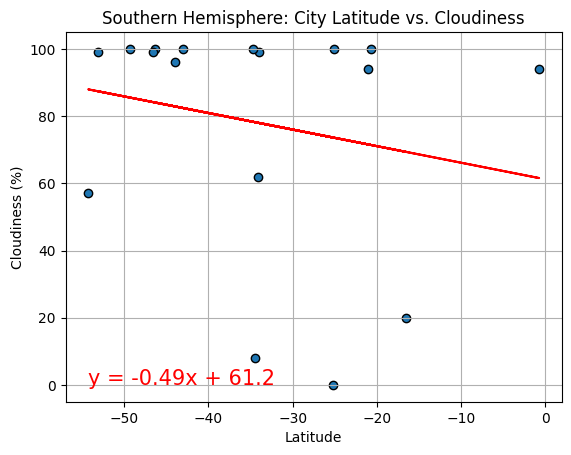

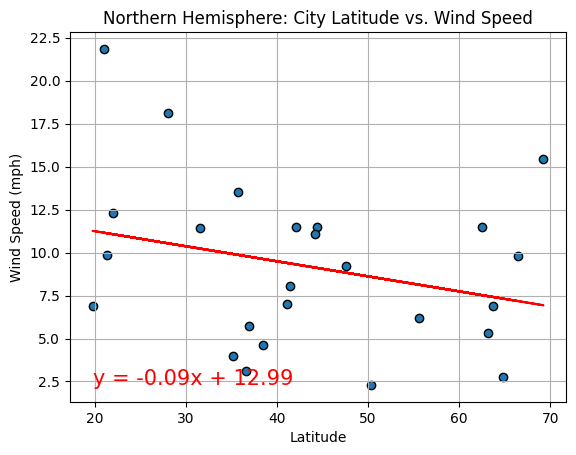

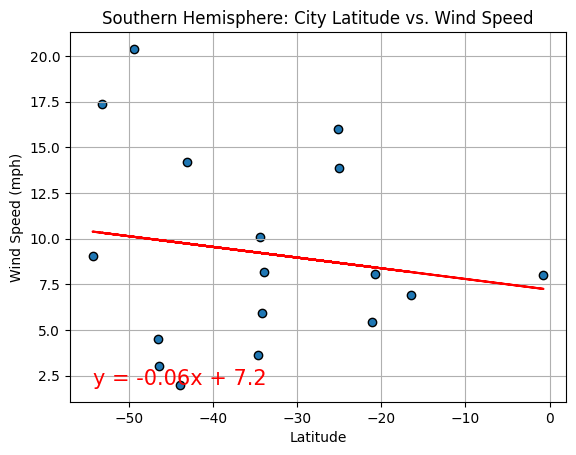

In [5]:

# Convert the cities weather data into a Pandas DataFrame
city_data_df = pd.DataFrame(city_data)

# Save the DataFrame to a CSV file
city_data_df.to_csv("output_data/cities.csv", index=False)

# Display sample data
print(city_data_df.head())

# Create the scatter plots requested
# Latitude vs. Temperature
plt.scatter(city_data_df["Lat"], city_data_df["Max Temp"], marker="o", edgecolor="black")
plt.title("City Latitude vs. Max Temperature")
plt.xlabel("Latitude")
plt.ylabel("Max Temperature (F)")
plt.grid(True)

# Save the figure
plt.savefig("output_data/Fig1.png")

# Show plot
plt.show()

# Latitude vs Humidity
plt.scatter(city_data_df["Lat"], city_data_df["Humidity"], marker="o", edgecolor="black")
plt.title("City Latitude vs. Humidity")
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")
plt.grid(True)

# Save the figure
plt.savefig("output_data/Fig2.png")

# Show plot
plt.show()

# Latitude vs Cloudiness
plt.scatter(city_data_df["Lat"], city_data_df["Cloudiness"], marker="o", edgecolor="black")
plt.title("City Latitude vs. Cloudiness")
plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")
plt.grid(True)

# Save the figure
plt.savefig("output_data/Fig3.png")

# Show plot
plt.show()

# Latitude vs Wind Speed
plt.scatter(city_data_df["Lat"], city_data_df["Wind Speed"], marker="o", edgecolor="black")
plt.title("City Latitude vs. Wind Speed")
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (mph)")
plt.grid(True)

# Save the figure
plt.savefig("output_data/Fig4.png")

# Show plot
plt.show()

# Requirement 2: Compute linear regression for each relationship
def plot_linear_regression(x_values, y_values, title, xlabel, ylabel):
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
    regress_values = x_values * slope + intercept
    line_eq = f"y = {round(slope, 2)}x + {round(intercept, 2)}"
    
    plt.scatter(x_values, y_values, marker="o", edgecolor="black")
    plt.plot(x_values, regress_values, "r-")
    plt.annotate(line_eq, (x_values.min(), y_values.min()), fontsize=15, color="red")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

# Create a DataFrame with the Northern Hemisphere data (Latitude >= 0)
northern_hemi_df = city_data_df[city_data_df["Lat"] >= 0]

# Create a DataFrame with the Southern Hemisphere data (Latitude < 0)
southern_hemi_df = city_data_df[city_data_df["Lat"] < 0]

# Temperature vs. Latitude Linear Regression
plot_linear_regression(northern_hemi_df["Lat"], northern_hemi_df["Max Temp"], 
                       "Northern Hemisphere: City Latitude vs. Max Temperature", 
                       "Latitude", "Max Temperature (F)")

plot_linear_regression(southern_hemi_df["Lat"], southern_hemi_df["Max Temp"], 
                       "Southern Hemisphere: City Latitude vs. Max Temperature", 
                       "Latitude", "Max Temperature (F)")

# Humidity vs. Latitude Linear Regression
plot_linear_regression(northern_hemi_df["Lat"], northern_hemi_df["Humidity"], 
                       "Northern Hemisphere: City Latitude vs. Humidity", 
                       "Latitude", "Humidity (%)")

plot_linear_regression(southern_hemi_df["Lat"], southern_hemi_df["Humidity"], 
                       "Southern Hemisphere: City Latitude vs. Humidity", 
                       "Latitude", "Humidity (%)")

# Cloudiness vs. Latitude Linear Regression
plot_linear_regression(northern_hemi_df["Lat"], northern_hemi_df["Cloudiness"], 
                       "Northern Hemisphere: City Latitude vs. Cloudiness", 
                       "Latitude", "Cloudiness (%)")

plot_linear_regression(southern_hemi_df["Lat"], southern_hemi_df["Cloudiness"], 
                       "Southern Hemisphere: City Latitude vs. Cloudiness", 
                       "Latitude", "Cloudiness (%)")

# Wind Speed vs. Latitude Linear Regression
plot_linear_regression(northern_hemi_df["Lat"], northern_hemi_df["Wind Speed"], 
                       "Northern Hemisphere: City Latitude vs. Wind Speed", 
                       "Latitude", "Wind Speed (mph)")

plot_linear_regression(southern_hemi_df["Lat"], southern_hemi_df["Wind Speed"], 
                       "Southern Hemisphere: City Latitude vs. Wind Speed", 
                       "Latitude", "Wind Speed (mph)")